In [1]:
from __future__ import division

import random
import math
import copy

import pandas as pd
import numpy as np

import seaborn as sns
sns.set_style('whitegrid')

from lentil import datatools
from lentil import datasynth
from lentil import viztools
from lentil import models
from lentil import est

%matplotlib inline

/usr/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import logging
logging.getLogger().setLevel(logging.DEBUG)

1. [One-dimensional Embedding](#One-dimensional-Embedding)
2. [Assessment Grid](#Assessment-Grid)
3. [Independent Assessments](#Independent-Assessments)
4. [Independent Lessons](#Independent-Lessons)
5. [Lesson Prerequisites](#Lesson-Prerequisites)

#### One-dimensional Embedding

A one-dimensional embedding, where a single latent skill is enough to explain the data. The key observation here is that the model recovered positive skill gains for $L_1$, and ``correctly" arranged students and assessments in the latent space. Initially, Carter fails both assessments, so his skill level is behind the requirements of both assessments. Lee passes $A_1$ but fails $A_2$, so his skill level is beyond the requirement for $A_1$, but behind the requirement for $A_2$. In an effort to improve their results, Lee and Carter complete lesson $L_1$ and retake both assessments. Now Carter passes $A_1$, but still fails $A_2$, so his new skill level is ahead of the requirements for $A_1$ but behind the requirements for $A_2$. Lee passes both assessments, so his new skill level exceeds the requirements for $A_1$ and $A_2$. This clear difference in results before completing lesson $L_1$ and after completing the lesson implies that $L_1$ had a positive effect on Lee and Carter's skill levels, hence the non-zero skill gain vector recovered for $L_1$.

In [3]:
data = []

def complete_assessment(student_id, assessment_id, outcome, timestep):
    data.append(
        {'module_id' : assessment_id,
         'module_type' : datatools.AssessmentInteraction.MODULETYPE,
         'outcome' : outcome,
         'student_id' : student_id,
         'timestep' : timestep})

def complete_lesson(student_id, lesson_id, timestep):
    data.append(
        {'module_id' : lesson_id,
         'module_type' : datatools.LessonInteraction.MODULETYPE,
         'student_id' : student_id,
         'timestep' : timestep})

complete_assessment('Lee', 'A1', True, 1)
complete_assessment('Carter', 'A1', False, 1)
complete_assessment('Lee', 'A2', False, 1)
complete_assessment('Carter', 'A2', False, 1)

complete_lesson('Lee', 'L1', 2)
complete_lesson('Carter', 'L1', 2)

complete_assessment('Lee', 'A1', True, 2)
complete_assessment('Carter', 'A1', True, 2)
complete_assessment('Lee', 'A2', True, 2)
complete_assessment('Carter', 'A2', False, 2)

history = datatools.InteractionHistory(pd.DataFrame(data))
history.squash_timesteps()
print(history.data)

  module_id module_type outcome student_id  timestep  \
0        A1  assessment    True        Lee         1   
1        A1  assessment   False     Carter         1   
2        A2  assessment   False        Lee         1   
3        A2  assessment   False     Carter         1   
4        L1      lesson     NaN        Lee         2   
5        L1      lesson     NaN     Carter         2   
6        A1  assessment    True        Lee         2   
7        A1  assessment    True     Carter         2   
8        A2  assessment    True        Lee         2   
9        A2  assessment   False     Carter         2   

   time_since_previous_interaction  duration  timestamp  
0                              NaN       NaN        NaN  
1                              NaN       NaN        NaN  
2                              NaN       NaN        NaN  
3                              NaN       NaN        NaN  
4                              NaN       NaN        NaN  
5                              NaN 

In [4]:
embedding_dimension = 2

model = models.EmbeddingModel(
    history, 
    embedding_dimension,
    using_lessons=True,
    using_prereqs=False,
    using_bias=False,
    learning_update_variance_constant=0.5)

gradient_descent_kwargs = {
    'using_adagrad' : False,
    'rate' : 0.1,
    'debug_mode_on' : False
}

estimator = est.EmbeddingMAPEstimator(
    regularization_constant=0.01,
    gradient_descent_kwargs=gradient_descent_kwargs,
    using_scipy=True,
    debug_mode_on=True,
    verify_gradient=True)

model.fit(estimator)

In [5]:
def my_plot_embedding(model, timestep):
    """
    Convenience function for calling plot_embedding with custom parameters
    without re-typing all of them
    """
    viztools.plot_embedding(
        model, 
        timestep,
        title="Latent Skill Space at Timestep " + str(timestep if timestep!=-1 else model.history.duration()-1),
        show_student_ids=True,
        show_assessment_ids=True,
        show_lesson_ids=True,
        id_padding_x=0.,
        id_padding_y=0.1,
        show_legend=False,
        force_invariant_axis_limits=True,
        axis_limit_padding=0.4,
        x_axis_limits=None,
        y_axis_limits=None)

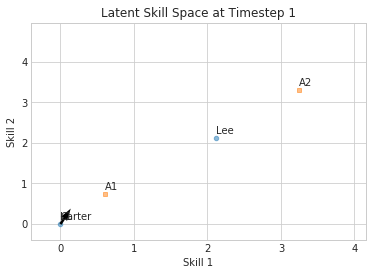

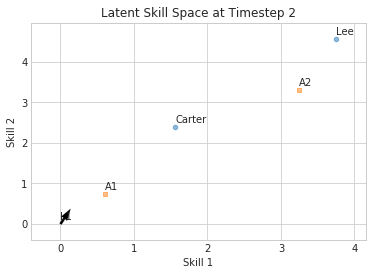

In [6]:
for i in range(1, model.history.duration()):
    my_plot_embedding(model, i)

#### Assessment Grid

A two-dimensional grid of assessments and a single student
        somewhere in the middle of it

In [7]:
embedding_dimension = 2
num_assessments = 100
num_attempts = 50

id_of_assessment_idx = lambda idx: 'A' + str(idx + 1)

def sample_students():
    """
    Fixed at (0.5, 0.5)
    """
    duration = 2
    S = np.zeros((1, embedding_dimension, duration))
    S.fill(0.5)
    return S
    
def sample_assessments():
    """
    Uniform grid from (0,0) to (1,1),
    excluding (1,1)
    """
    A = np.zeros((num_assessments,
                  embedding_dimension))
    grid_length = int(math.sqrt(num_assessments))
    for i in range(grid_length):
        for j in range(grid_length):
            A[i*grid_length+j, 0] = 1 / grid_length * i
            A[i*grid_length+j, 1] = 1 / grid_length * j
    return A
    
def sample_lessons():
    """
    No lessons
    """
    return None

def sample_prereqs():
    """
    No lesson prereqs
    """
    return None

def sample_interactions(model):
    """
    student works on assessment 1 [num_attempts] times
    student works on assessment 2 [num_attempts] times
    .
    .
    .
    student works on assessment [num_assessments] [num_attempts] times
    """
    data = []

    student_id = 'Carl'
    student = model.student_embeddings[0, :, 1]
    student_bias = 0
    for i in range(num_assessments):
        assessment_id = id_of_assessment_idx(i)
        assessment = model.assessment_embeddings[i, :]
        assessment_bias = 0
        pass_likelihood = math.exp(model.assessment_outcome_log_likelihood_helper(student, assessment, student_bias, assessment_bias, 1))
        for j in range(num_attempts):
            timestep = 1+i*num_attempts + j
            outcome = random.random() < pass_likelihood

            data.append(
                {'module_id' : assessment_id, 
                 'module_type' : datatools.AssessmentInteraction.MODULETYPE, 
                 'outcome' : outcome, 
                 'student_id' : student_id, 
                 'timestep' : timestep})
        
    return pd.DataFrame(data)

In [8]:
embedding_kwargs = {
    'embedding_dimension' : embedding_dimension,
    'using_lessons' : False,
    'using_prereqs' : False,
    'using_bias' : False,
    'learning_update_variance_constant' : 0.5
}

model = datasynth.sample_synthetic_model_and_history(
    sample_students, 
    sample_assessments,
    sample_interactions,
    sample_lessons=sample_lessons,
    sample_prereqs=sample_prereqs,
    embedding_kwargs=embedding_kwargs)

num_students = model.student_embeddings.shape[0]
num_assessments = model.assessment_embeddings.shape[0]
model.student_biases = np.zeros(num_students)
model.assessment_biases = np.zeros(num_assessments)

assessment_idx_map = {id_of_assessment_idx(i):i for i in range(num_assessments)}
model.history.compute_idx_maps(assessment_idx=assessment_idx_map)

model.history.squash_timesteps()

true_model = copy.deepcopy(model)
print(model.history.data)

TypeError: '>=' not supported between instances of 'int' and 'NoneType'

In [10]:
gradient_descent_kwargs = {
    'using_adagrad' : False,
    'rate' : 0.0005,
    'ftol' : 1e-5,
    'debug_mode_on' : True
}

estimator = est.EmbeddingMAPEstimator(
    regularization_constant=0.01,
    gradient_descent_kwargs=gradient_descent_kwargs,
    using_scipy=True,
    ftol=1e-3,
    debug_mode_on=True,
    verify_gradient=True)

model.fit(estimator)

In [11]:
def my_plot_embedding(model, timestep, title=None):
    """
    Convenience function for calling plot_embedding with custom parameters
    without re-typing all of them
    """
    viztools.plot_embedding(
        model, 
        timestep,
        title=title if title is not None else ("Latent Skill Space at Timestep " + str(timestep if timestep!=-1 else model.history.duration()-1)),
        show_student_ids=True,
        show_assessment_ids=False,
        show_lesson_ids=False,
        show_lessons=False,
        show_prereqs=False,
        id_padding_x=0.,
        id_padding_y=0.,
        show_legend=False,
        force_invariant_axis_limits=True,
        axis_limit_padding=0.1,
        show_pass_rates=True,
        size=60,
        x_axis_limits=None,
        y_axis_limits=None)

In [12]:
my_plot_embedding(true_model, -1, title='True Embedding')

NameError: name 'true_model' is not defined

Showing pass rates for more than one student!


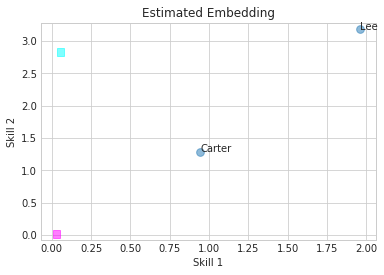

In [13]:
my_plot_embedding(model, -1, title='Estimated Embedding')

#### Independent Assessments

A two-dimensional embedding, where an intransitivity in assessment results requires more than one latent skill to explain. The key observation here is that the assessments are embedded on two different axes, meaning they require two completely independent skills. This makes sense, since student results on $A_1$ are uncorrelated with results on $A_2$. Fogell fails both assessments, so his skill levels are behind the requirements for $A_1$ and $A_2$. McLovin passes both assessments, so his skill levels are beyond the requirements for $A_1$ and $A_2$. Evan and Seth are each able to pass one assessment but not the other. Since the assessments have independent requirements, this implies that Evan and Seth have independent skill sets (i.e. Evan has enough of skill 2 to pass $A_2$ but not enough of skill 1 to pass $A_1$, and Seth has enough of skill 1 to pass $A_1$ but not enough of skill 2 to pass $A_2$).

In [ ]:
data = []

def complete_assessment(module_id, student_id, outcome, timestep):
    data.append(
        {'module_id' : module_id, 
         'module_type' : datatools.AssessmentInteraction.MODULETYPE, 
         'outcome' : outcome, 
         'student_id' : student_id, 
         'timestep' : timestep})

complete_assessment('A1', 'McLovin', True, 1)
complete_assessment('A2', 'McLovin', True, 2)

complete_assessment('A1', 'Fogell', False, 1)
complete_assessment('A2', 'Fogell', False, 2)

complete_assessment('A1', 'Seth', True, 1)
complete_assessment('A2', 'Seth', False, 2)

complete_assessment('A1', 'Evan', False, 1)
complete_assessment('A2', 'Evan', True, 3)

history = datatools.InteractionHistory(pd.DataFrame(data))
history.squash_timesteps()
print(history.data)

In [ ]:
embedding_dimension = 2

model = models.EmbeddingModel(
    history, 
    embedding_dimension,
    using_prereqs=False,
    using_lessons=False,
    using_bias=False,
    learning_update_variance_constant=0.5)

gradient_descent_kwargs = {
    'using_adagrad' : False,
    'rate' : 0.1,
    'debug_mode_on' : True
}

estimator = est.EmbeddingMAPEstimator(
    regularization_constant=1e-3,
    gradient_descent_kwargs=gradient_descent_kwargs,
    using_scipy=True,
    debug_mode_on=True,
    verify_gradient=True)

model.fit(estimator)

In [ ]:
def my_plot_embedding(model, timestep):
    """
    Convenience function for calling plot_embedding with custom parameters
    without re-typing all of them
    """
    viztools.plot_embedding(
        model, 
        timestep,
        title="Latent Skill Space at Timestep " + str(timestep if timestep!=-1 else model.history.duration()-1),
        show_student_ids=True,
        show_assessment_ids=True,
        show_lesson_ids=False,
        id_padding_x=0.,
        id_padding_y=0.05,
        show_legend=False,
        force_invariant_axis_limits=True,
        axis_limit_padding=0.1,
        show_pass_rates=False,
        size=20,
        x_axis_limits=None,
        y_axis_limits=None)

In [ ]:
my_plot_embedding(model, 1)

#### Independent Lessons

We replicate the setting in [Independent Assessments](#Independent-Assessments), then add two new students Slater and Michaels, and two new lesson modules $L_1$ and $L_2$. Slater is initially identical to Evan, while Michaels is initially identical to Seth. Slater reads lesson $L_1$, then passes assessments $A_1$ and $A_2$. Michaels reads lesson $L_2$, then passes assessments $A_1$ and $A_2$. The key observation here is that the skill gain vectors recovered for the two lesson modules are orthogonal, meaning they help students satisfy completely independent skill requirements. This makes sense, since initially Slater was lacking in Skill 1 while Michaels was lacking in Skill 2, but after completing their lessons they passed their assessments, showing that they gained from their respective lessons what they were lacking initially.

In [ ]:
data = []

def complete_lesson(lesson_id, student_id, timestep):
    data.append(
        {'module_id' : lesson_id, 
         'module_type' : datatools.LessonInteraction.MODULETYPE, 
         'outcome' : None, 
         'student_id' : student_id, 
         'timestep' : timestep})

def complete_assessment(assessment_id, student_id, outcome, start_time):
    data.append(
        {'module_id' : assessment_id, 
         'module_type' : datatools.AssessmentInteraction.MODULETYPE, 
         'outcome' : outcome, 
         'student_id' : student_id, 
         'timestep' : start_time})

complete_assessment('A1', 'McLovin', True, 1)
complete_assessment('A2', 'McLovin', True, 2)

complete_assessment('A1', 'Fogell', False, 1)
complete_assessment('A2', 'Fogell', False, 2)

complete_assessment('A1', 'Seth', True, 1)
complete_assessment('A2', 'Seth', False, 2)

complete_assessment('A1', 'Evan', False, 1)
complete_assessment('A2', 'Evan', True, 3)

complete_assessment('A1', 'Michaels', True, 1)
complete_assessment('A2', 'Michaels', False, 1)

complete_assessment('A1', 'Slater', False, 1)
complete_assessment('A2', 'Slater', True, 1)

complete_lesson('L1', 'Michaels', 4)
complete_lesson('L2', 'Slater', 4)

complete_assessment('A1', 'Michaels', True, 5)
complete_assessment('A2', 'Michaels', True, 6)

complete_assessment('A1', 'Slater', True, 5)
complete_assessment('A2', 'Slater', True, 6)

history = datatools.InteractionHistory(pd.DataFrame(data))
history.squash_timesteps()
print(history.data)

In [ ]:
embedding_dimension = 2

model = models.EmbeddingModel(
    history, 
    embedding_dimension,
    using_prereqs=False,
    using_lessons=True,
    using_bias=False,
    learning_update_variance_constant=0.5) 

gradient_descent_kwargs = {
    'using_adagrad' : False,
    'rate' : 0.1,
    'debug_mode_on' : True
}

estimator = est.EmbeddingMAPEstimator(
    regularization_constant=1e-3,
    gradient_descent_kwargs=gradient_descent_kwargs,
    using_scipy=True,
    debug_mode_on=True,
    verify_gradient=True)

model.fit(estimator)

In [ ]:
def my_plot_embedding(model, timestep):
    """
    Convenience function for calling plot_embedding with custom parameters
    without re-typing all of them
    """
    viztools.plot_embedding(
        model, 
        timestep,
        title="Latent Skill Space at Timestep " + str(timestep if timestep!=-1 else model.history.duration()-1),
        show_student_ids=True,
        show_assessment_ids=True,
        show_lesson_ids=True,
        show_lessons=True,
        id_padding_x=0.,
        id_padding_y=0.05,
        show_legend=False,
        force_invariant_axis_limits=True,
        axis_limit_padding=0.1,
        show_pass_rates=False,
        size=20,
        x_axis_limits=None,
        y_axis_limits=None)

In [ ]:
for i in range(1, model.history.duration()):
    my_plot_embedding(model, i)

#### Lesson Prerequisites

We replicate the setting in [Independent Assessments](#Independent-Assessments), then add a new assessment module $A_3$ and a new lesson module $L_1$. All students initially fail assessment $A_3$, then read lesson $L_1$, after which McLovin passes $A_3$ while everyone else still fails $A_3$. The key observation here is that McLovin is the only student who initially satisfies the prerequisites for $L_1$, so he is the only student who realizes significant gains.

In [ ]:
data = []

def complete_assessment(assessment_id, student_id, outcome, timestep):
    data.append(
        {'module_id' : assessment_id, 
         'module_type' : datatools.AssessmentInteraction.MODULETYPE, 
         'outcome' : outcome, 
         'student_id' : student_id, 
         'timestep' : timestep})

def complete_lesson(lesson_id, student_id, timestep):
    data.append(
        {'module_id' : lesson_id, 
         'module_type' : datatools.LessonInteraction.MODULETYPE, 
         'outcome' : None, 
         'student_id' : student_id, 
         'timestep' : timestep})

complete_assessment('A1', 'McLovin', True, 1)
complete_assessment('A2', 'McLovin', True, 2)

complete_assessment('A1', 'Fogell', False, 1)
complete_assessment('A2', 'Fogell', False, 2)

complete_assessment('A1', 'Seth', True, 1)
complete_assessment('A2', 'Seth', False, 2)

complete_assessment('A1', 'Evan', False, 1)
complete_assessment('A2', 'Evan', True, 3)

complete_assessment('A3', 'McLovin', False, 4)
complete_assessment('A3', 'Fogell', False, 4)
complete_assessment('A3', 'Seth', False, 4)
complete_assessment('A3', 'Evan', False, 4)

complete_lesson('L1', 'McLovin', 5)
complete_lesson('L1', 'Fogell', 5)
complete_lesson('L1', 'Seth', 5)
complete_lesson('L1', 'Evan', 5)

complete_assessment('A3', 'McLovin', True, 6)

complete_assessment('A3', 'Fogell', False, 6)
complete_assessment('A3', 'Seth', False, 6)
complete_assessment('A3', 'Evan', False, 6)

history = datatools.InteractionHistory(pd.DataFrame(data))
history.squash_timesteps()
print(history.data)

In [ ]:
embedding_dimension = 2

model = models.EmbeddingModel(
    history,
    embedding_dimension,
    using_lessons=True,
    using_prereqs=True,
    using_bias=False,
    learning_update_variance_constant=0.5)  

gradient_descent_kwargs = {
    'using_adagrad' : False,
    'rate' : 0.01,
    'ftol' : 1e-4,
    'debug_mode_on' : True
}

estimator = est.EmbeddingMAPEstimator(
    regularization_constant=1e-3,
    gradient_descent_kwargs=gradient_descent_kwargs,
    using_scipy=True,
    debug_mode_on=True,
    verify_gradient=True)

model.fit(estimator)

In [ ]:
def my_plot_embedding(model, timestep):
    """
    Convenience function for calling plot_embedding with custom parameters
    without re-typing all of them
    """
    viztools.plot_embedding(
        model, 
        timestep,
        title="Latent Skill Space at Timestep " + str(timestep),
        show_student_ids=True,
        show_assessment_ids=True,
        show_lesson_ids=True,
        id_padding_x=-0.01,
        id_padding_y=0.01,
        show_legend=False,
        force_invariant_axis_limits=True,
        axis_limit_padding=0.4,
        x_axis_limits=None,
        y_axis_limits=None)

In [ ]:
for i in range(1, model.history.duration()):
    my_plot_embedding(model, i)